In [1]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
from datetime import datetime
import xgboost as xgb
import seaborn as sns
from tqdm import tqdm
import json


from catboost import CatBoostClassifier 
from sklearn.metrics import accuracy_score 

import sklearn.metrics

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

2024-09-06 15:03:52.364029: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-06 15:03:53.204964: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

df = pd.read_feather("data/merged_with_weather.feather")
df = df.loc[np.isnan(df['t2m']) == False, list(df.columns[:12]) + list(df.columns[20:])]

df = df.dropna()
print(df.shape)

(566507, 57)


## Visualize Data

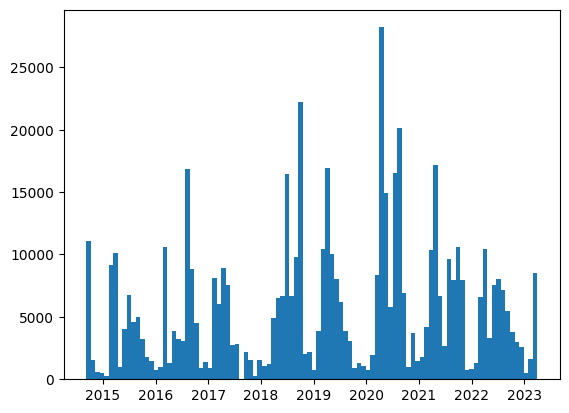

In [3]:
import matplotlib.dates as mdates

data = df['datetime']

mpl_data = mdates.date2num(data)

# plot it
fig, ax = plt.subplots(1,1)
ax.hist(mpl_data, bins=100)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

# Prepare Data

In [4]:
prohibited = ["ICOS", "time_stamp", "level_0", "index", "datetime", "value_std_dev", "station_dist", "station_lat", "station_lon", "id", "dates"]# + ["lat", "lon", "hours_since_2014_1_1"]
predictors = [c for c in df if c not in prohibited and "station" not in c]
target = 'ICOS'
print(predictors, "->", target)
print(" ")

test_stations = ['station_KRE', 'station_SVB', 'station_HEL', 'station_TRN']#['station_OPE', 'station_ZSF', 'station_HPB']#['station_HPB', 'station_OXK']#["station_GAT", "station_NOR", "station_OXK"]['station_PUY', 'station_HPB'],['station_OPE', 'station_ZSF', 'station_HPB'],

['lat', 'lon', 'OCO2', 'hours_since_2014_1_1', 't2m', 'd2m', 'tp', 'swvl1', 'sp', 'u10', 'v10', 'cape', 'skt', 'tcc'] -> ICOS
 


In [7]:
def split_data(df, test_stations):
    if 'station_dist' in df.columns: 
        pass#df = df[df['station_dist'] < 40000]

    filtr = sum(df[s] for s in test_stations) > 0
    train = df[filtr == False]
    test = df[filtr == True]
    print("Test set fraction", np.mean(filtr))
    return train, test

def get_datasets(train, test, config):

    predictors = config['predictors']
    target = config['target']

    Xt = train[predictors]
    yt = train[target]

    Xv = test[predictors]
    yv = test[target]

    mX = np.mean(Xt, axis=0).values
    sX = np.std(Xt, axis=0).values
    sX[sX == 0] = 1
    Xt = (Xt-mX)/sX
    Xv = (Xv-mX)/sX

    my = np.mean(yt)
    sy = np.std(yt)
    if config['model'] != "catboost":
        yt = (yt-my)/sy
        yv = (yv-my)/sy

    config['n_par'] = Xv.shape[1]

    config['norm_info'] = (mX, sX, my, sy)

    return Xt, yt, Xv, yv, config

def unnormalize(true, pred, config):
    if config['model'] == "catboost":
        bins = config['norm_info']
        new_pred = np.zeros(pred.shape)
        true = true.values
        for i in range(config['n_cats']): 
            new_pred[pred == i] = bins[i]
        return new_pred, true
    
    norm_info = config['norm_info']
    return true*norm_info[3] + norm_info[2], pred*norm_info[3] + norm_info[2]


def evaluate_model(true, pred, config):
    n_par = config['n_par']
    corr = np.corrcoef(pred, true)[0,1]
    rmse = np.sqrt(np.mean((pred - true)**2))
    mse = np.mean((pred - true)**2)
    r2 = sklearn.metrics.r2_score(true, pred)
    r2_adj = 1-(1-r2)*(len(pred)-1)/(len(pred)-n_par)

    config['metrics'] = {
        'r2': r2,
        'rmse': rmse,
        'mse': mse,
        'r2_adj': r2_adj,
        'corr': corr,
    }
    config['result'] = {
        'pred': pred,
        'true': true
    }

    return config


def plot_result(config, colors, rows, cols, subplot_index, show_metrics=True):

    ax = plt.subplot(rows, cols, subplot_index)
    for i in np.unique(colors):
        plt.scatter([0], [0], alpha=0, s=6, color=plt.colormaps['viridis'](i/(len(np.unique(colors))-1)))

    plt.scatter(config['result']['true'], config['result']['pred'], alpha=0.2, s=6, c=colors)
    plt.plot([390, 440], [390, 440], "k--")
    #plt.xlabel('ICOS')
    #plt.ylabel('pred')
    plt.xlim([390, 440])
    plt.ylim([390, 440])
    plt.xticks([390, 415,440], ['390', '415', '440'])
    plt.yticks([390, 415,440], ['390', '415', '440'])
    plt.title(config['name'])
    leg = plt.legend([t.replace('station_', 'station ') for t in config['test_stations']])
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    if show_metrics:
        y = 0
        d = 0.05
        for metric in config['metrics']:
            plt.text(1, y, metric + ":" +      str(np.round(config['metrics'][metric], 3)),     horizontalalignment='right', verticalalignment='bottom', transform = ax.transAxes)
            y += d

    subplot_index += 1
    return subplot_index

In [8]:
def create_model(config):
    kind = config['model']
    if kind == "xgb":
        return xgb.XGBRegressor()
    elif kind == "neural":
        model = keras.Sequential(
            [layers.Dense(sz, activation='relu', kernel_regularizer='l2') for sz in config['layers']] + 
            [layers.Dense(1, kernel_regularizer='l2')]
        )
        model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(config['lr']))
        return model
    elif kind == "catboost":
        return CatBoostClassifier(iterations=config['iterations'], learning_rate=config['lr'], depth=config['depth']) 
    

def categorize_data(yt, yv, config): 
    bins = []
    N = config['n_cats']
    cat_yt = -1*np.ones(yt.shape)
    cat_yv = -1*np.ones(yv.shape)
    for i in range(N):
        t = np.percentile(yt.values, 100*i/N)
        cat_yt[yt >= t] = i
        cat_yv[yv >= t] = i
        bins.append(np.percentile(yt.values, 100*(i+0.5)/N))
    config['norm_info'] = bins
    return cat_yt, cat_yv, config

In [ ]:

subplot_rows = 1
subplot_cols = 4
plt.figure(figsize=(subplot_cols*5, subplot_rows*5))
subplot_index = 1

results = {}

trainset, testset = split_data(df, test_stations)


colors = np.zeros(testset.shape[0]).astype(int)
for i,s in enumerate(test_stations):
    colors[testset[s] == 1] = i
    

# Baseline
config = {
    'name': 'Baseline',
    'model': 'xgb',
    'test_stations': test_stations,
    'predictors': ['OCO2'],
    'target': target
}
Xt, yt, Xv, yv, config = get_datasets(trainset, testset, config)
model = create_model(config)
model.fit(Xt, yt)
yp = model.predict(Xv)
true, pred = unnormalize(yv, yp, config)
config = evaluate_model(true, pred, config)
subplot_index = plot_result(config, colors, subplot_rows, subplot_cols, subplot_index)
results[config['name']] = config


# XGB Reg
config = {
    'name': 'Extreme Gradient Boosting',
    'model': 'xgb',
    'test_stations': test_stations,
    'predictors': predictors,
    'target': target
}
Xt, yt, Xv, yv, config = get_datasets(trainset, testset, config)
model = create_model(config)
model.fit(Xt, yt)
yp = model.predict(Xv)
true, pred = unnormalize(yv, yp, config)
config = evaluate_model(true, pred, config)
subplot_index = plot_result(config, colors, subplot_rows, subplot_cols, subplot_index)
results[config['name']] = config




# Category Boosting
config = {
    'name': 'Category Boosting',
    'model': 'catboost',
    'test_stations': test_stations,
    'predictors': predictors,
    'target': target,
    'n_cats': 25,
    'iterations': 100,
    'lr': 0.1,
    'depth': 6
}
Xt, yt, Xv, yv, config = get_datasets(trainset, testset, config)
cat_yt, cat_yv, config = categorize_data(yt, yv, config)
model = create_model(config)

model.fit(Xt, cat_yt, verbose=0)
cat_yp = model.predict(Xv).reshape(-1)
print("Accuracy:", accuracy_score(cat_yv, cat_yp)) 

true, pred = unnormalize(yv, cat_yp, config)
config = evaluate_model(true, pred, config)
subplot_index = plot_result(config, colors, subplot_rows, subplot_cols, subplot_index)
results[config['name']] = config



# Neural Network
config = {
    'name': 'Neural Network Regression',
    'model': 'neural',
    'test_stations': test_stations,
    'predictors': predictors,
    'target': target,
    'layers': [64,128,64,32],
    'lr': 0.001
}
Xt, yt, Xv, yv, config = get_datasets(trainset, testset, config)
model = create_model(config)
history = model.fit(
    Xt,
    yt,
    epochs=100,
    verbose=1
)
yp = model.predict(Xv).reshape(-1)
true, pred = unnormalize(yv, yp, config)
config = evaluate_model(true, pred, config)
subplot_index = plot_result(config, colors, subplot_rows, subplot_cols, subplot_index)
results[config['name']] = config

neural_model = model






results

/tmp/ipykernel_191144/3842502765.py:92: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:
/tmp/ipykernel_191144/3842502765.py:92: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:
/tmp/ipykernel_191144/3842502765.py:92: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:
/tmp/ipykernel_191144/3842502765.py:92: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


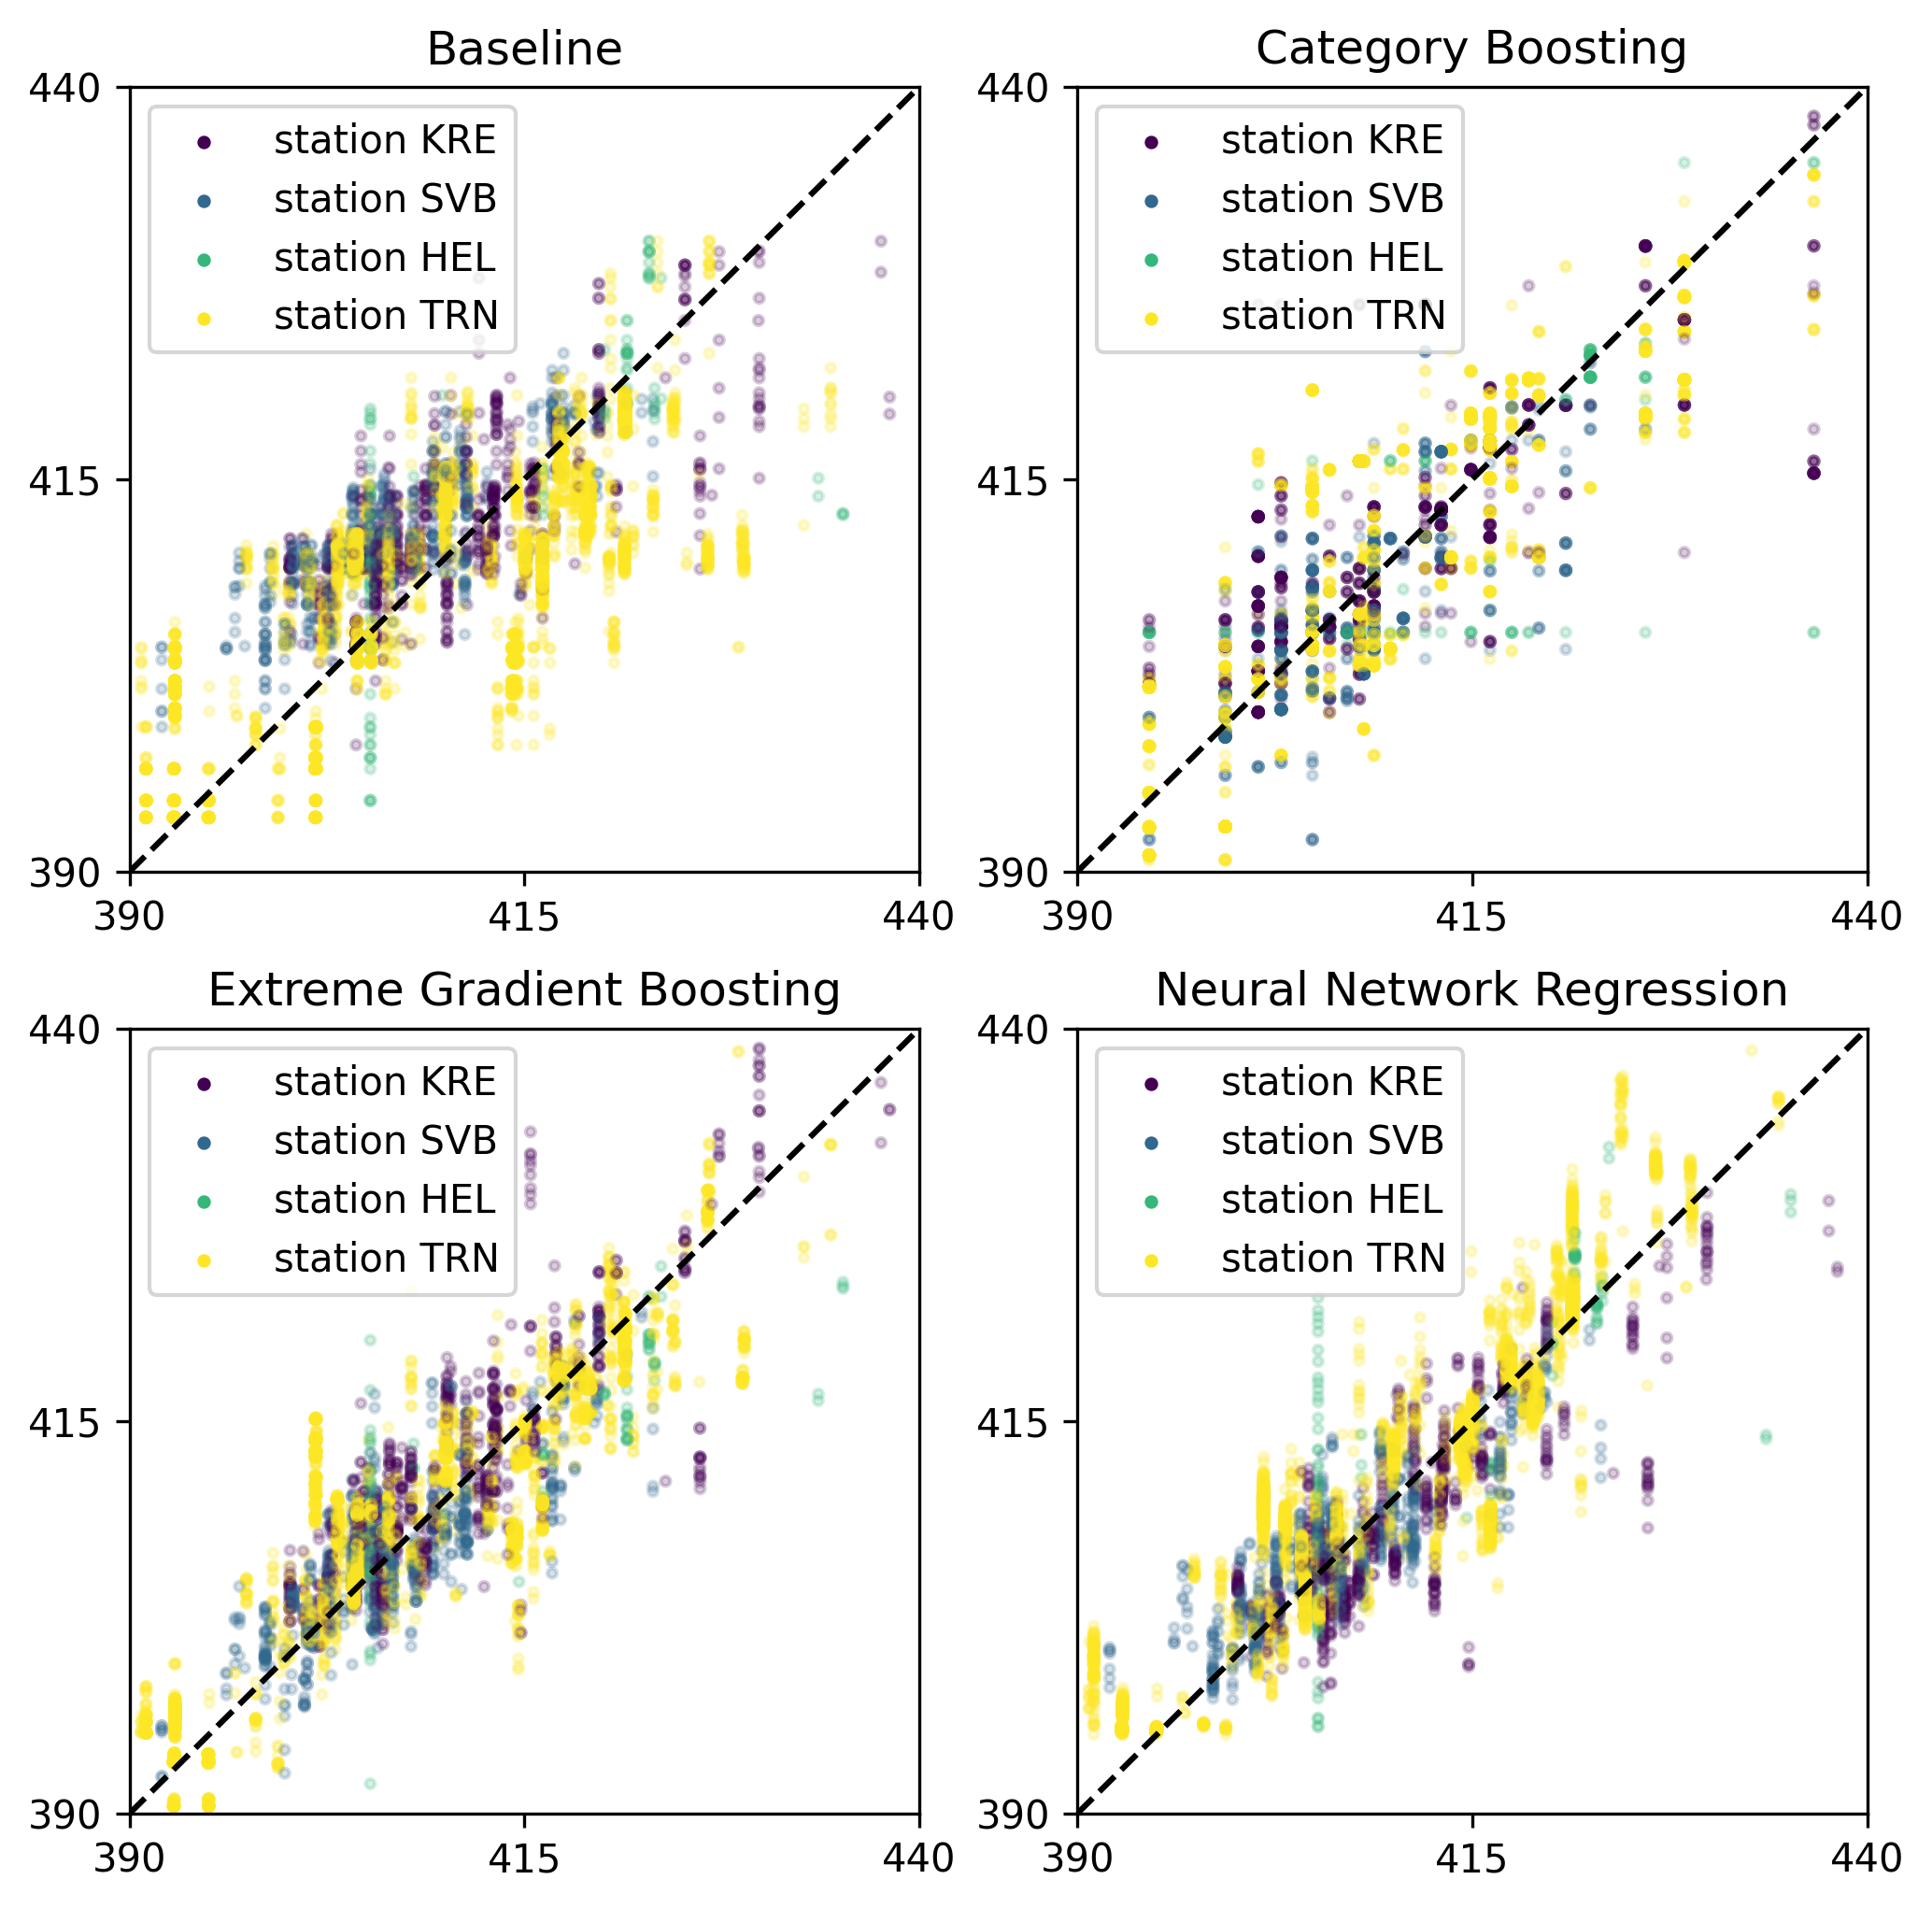

In [21]:

subplot_rows = 2
subplot_cols = 2
plt.figure(figsize=(subplot_cols*4, subplot_rows*4), dpi=300)
subplot_index = 1

for method in ['Baseline', 'Category Boosting', 'Extreme Gradient Boosting', 'Neural Network Regression']:
    config = results[method]
    subplot_index = plot_result(config, colors, subplot_rows, subplot_cols, subplot_index, show_metrics=False)

In [23]:

for method in results:
    if type(results[method]['result']['pred']) != list:
        results[method]['result']['pred'] = list(results[method]['result']['pred'].astype(float))
        results[method]['result']['true'] = list(results[method]['result']['true'].astype(float))
    if type(results[method]['norm_info']) == tuple:
        results[method]['norm_info'] = (
            list(results[method]['norm_info'][0].astype(float)),
            list(results[method]['norm_info'][1].astype(float)),
            results[method]['norm_info'][2],
            results[method]['norm_info'][3]
        )
    
os.makedirs("results", exist_ok=True)
time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
with open('results/config_' + time + '.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=4)

In [33]:
os.makedirs("models", exist_ok=True)
neural_model.save("models/model_" + time + ".keras")